# Figures 2 and 3
Figure panels for UCSF-Biohub COVID Tissue Atlas. <br>
Nov 2021 <br>
Authors: Alejandro Granados, Ann Chen <br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import sys
import matplotlib as mpl
import os 
#add path where utils.py will be called
sys.path.append('/mnt/ibm_lg/covid_tissue_atlas/CovidTissueAtlas/cta_utils/')
import utils
import viz_utils
from matplotlib import cm



# Notebook parameters 
this_sample ='heart'
FIG_DIR = viz_utils.setup_fig_params(this_sample )

# Location of organ h5ad 
MASTER_DIR = '/mnt/ibm_lg/covid_tissue_atlas/data/tissue_objects/all_tissues/portal/'
sc.settings.verbosity = 3            
sc.set_figure_params(dpi=150)
sc.settings.figdir = FIG_DIR




package versions:
matplotlib 3.3.1
scanpy 1.7.2


/data/alejandro/miniconda3/envs/scanpy/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


Make UMAPs and save pdf 

In [2]:
adata = sc.read_h5ad(MASTER_DIR + 'CTA_' + this_sample + '.h5ad')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


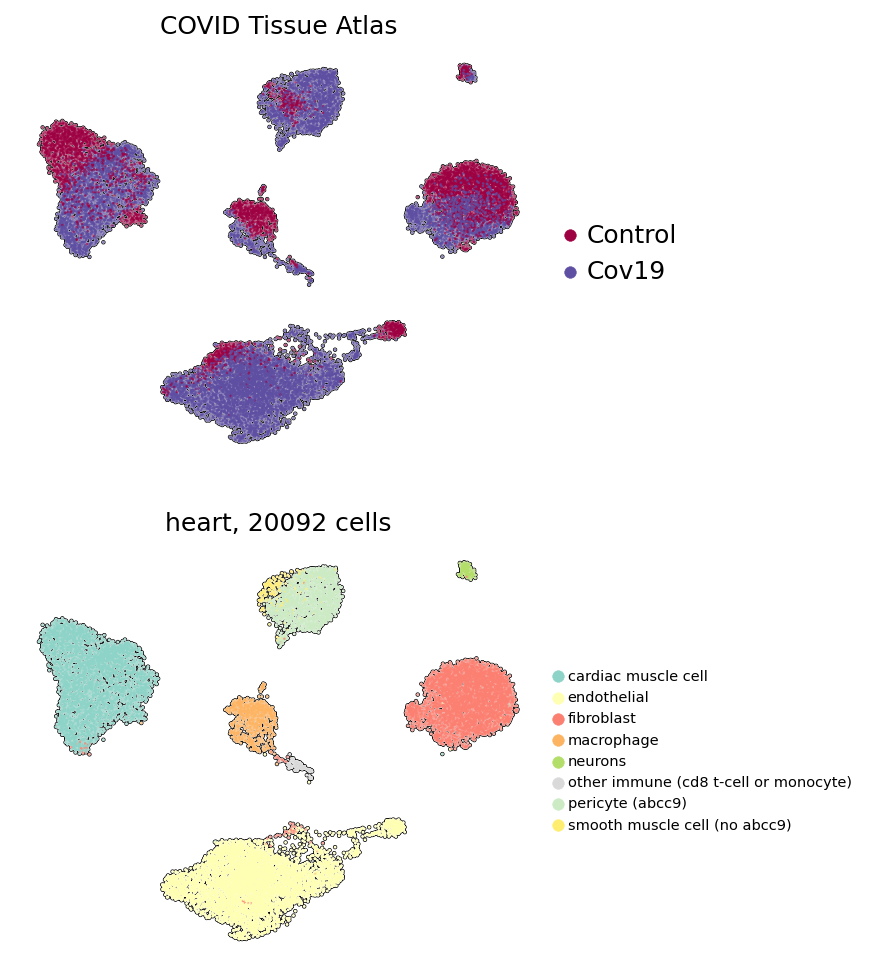

In [3]:
from matplotlib.pyplot import rc_context
viz_utils.set_plotting_style() 
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4.5,8))

n_cells  = adata.X.shape[0]

sc.pl.umap(adata, color='disease_status', add_outline=True, legend_loc='right margin',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='COVID Tissue Atlas', palette='Spectral',
               ax=ax[0], show = False)
    
sc.pl.umap(adata, color='cell_type_annotation', add_outline=True,
               legend_fontsize=7, legend_fontoutline=1,frameon=False,
               title= f'{this_sample}, {n_cells} cells', palette='Set3', 
               ax = ax[1])

fig.savefig(FIG_DIR + this_sample + '_umaps.svg', dpi=400, bbox_inches='tight', transparent=True)
plt.show() 

## Cell type populations

In [8]:
cell_type_label = 'short_cell_type'
stacked_df = adata.obs[['disease_status', cell_type_label]]
cluster_disease = stacked_df.pivot_table(index=cell_type_label, columns=['disease_status'], aggfunc='size')
cluster_disease_pct = cluster_disease.div(cluster_disease.sum(axis=0), axis=1) * 100
organs_covid = cluster_disease_pct.sort_values(by ="Cov19", ascending = False )


donor_col = 'sampleID'
# set plot style: grey grid in the background:
sns.set(style="whitegrid")

# set the figure size
df = adata.obs
# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
stacked_df = adata.obs[[donor_col, cell_type_label]]
cluster_disease = stacked_df.pivot_table(index = donor_col, columns= cell_type_label, aggfunc='size')
sorted_donors = cluster_disease.sum(axis = 1).sort_values()

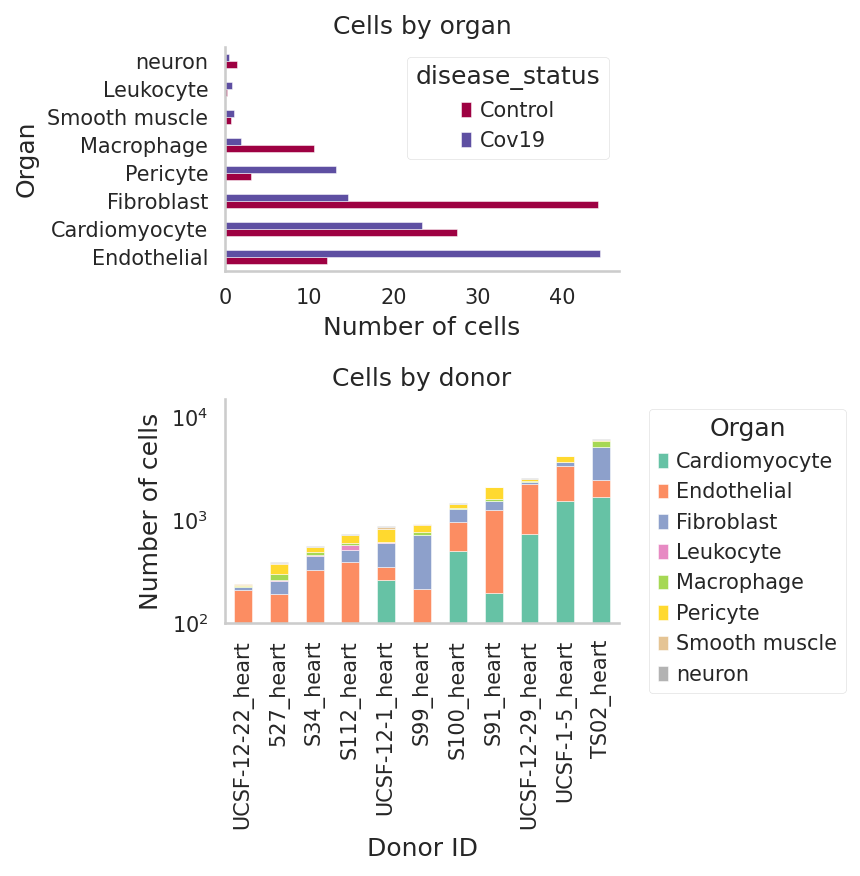

In [9]:
viz_utils.set_plotting_style() 

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,6), dpi = 150)

# Panel A 
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)
#ax[0].set_xscale('log')

organs_covid.plot(kind='barh', stacked=False, 
                     colormap=cmap,
                     grid = False,ax = ax[0])

# Panel B 
ax[1].set_yscale('log')
cmap = cm.get_cmap('Set2') # Colour map (there are many others)

cluster_disease.loc[sorted_donors.index].plot(kind='bar', 
                                              stacked=True, 
                                              ax = ax[1],
                                              cmap = cmap, 
                                              grid =False, ylim = (100,20000) )
ax[1].legend(bbox_to_anchor=(1.05, 1), title = 'Organ')
# plt.legend(loc='upper left', 
#             title='Organ'
#            )
plt.ylim((100,15000))

titles = ['Cells by organ', 'Cells by donor']
xlabels = ['Number of cells','Donor ID']
ylabels = ['Organ','Number of cells']

for i,axes in enumerate( ax.flat):
     viz_utils.stylize_axes(axes, titles[i], xlabels[i], ylabels[i])
        
plt.tight_layout()

fig.savefig(FIG_DIR + 'barplots_celltype.pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show() 
 

## Expression of COVID genes 

Storing dendrogram info using `.uns['dendrogram_short_cell_type']`
categories: Cardiomyocyte, Endothelial, Fibroblast, etc.
var_group_labels: Entry genes, Entry receptors, Entry proteases


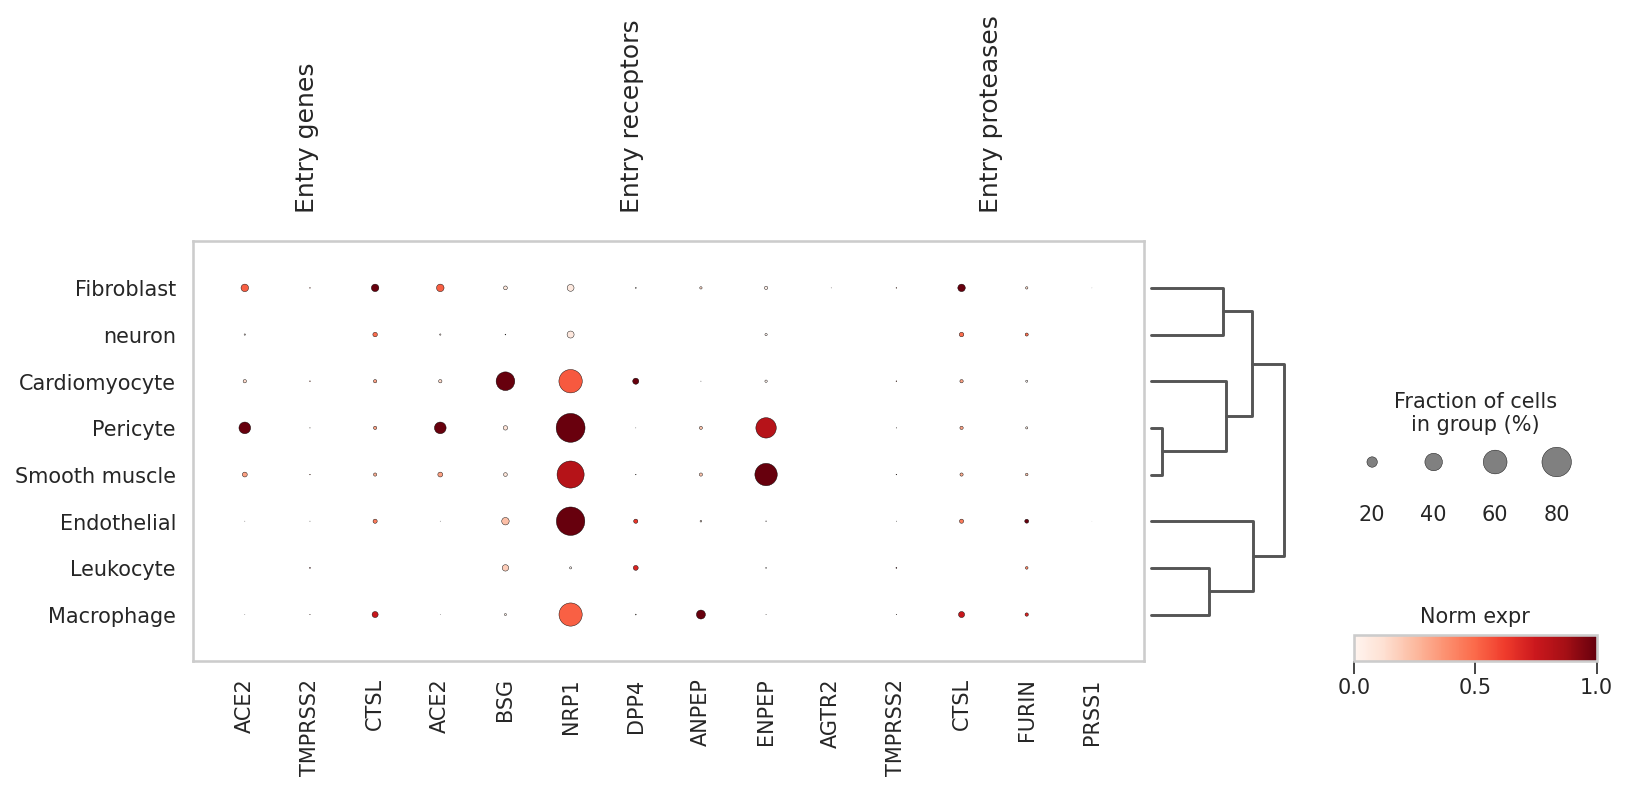

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12,5), gridspec_kw={'wspace':0.9})
sc.tl.dendrogram(adata, use_rep = 'X_scVI', groupby = cell_type_label) 
sc.pl.dotplot(adata, 
              var_names= utils.get_covid_genes() ,
              layer='counts',
              groupby=cell_type_label,
              log=True,
              standard_scale='var',
              colorbar_title = 'Norm expr',
              dendrogram=True, ax = ax1,
              save= this_sample + '_dotplot_COVID_genes.pdf')

## Expression of cell type markers 

categories: Cardiomyocyte, Endothelial, Fibroblast, etc.
var_group_labels: endothelial, cardiac muscle, fibroblast, etc.


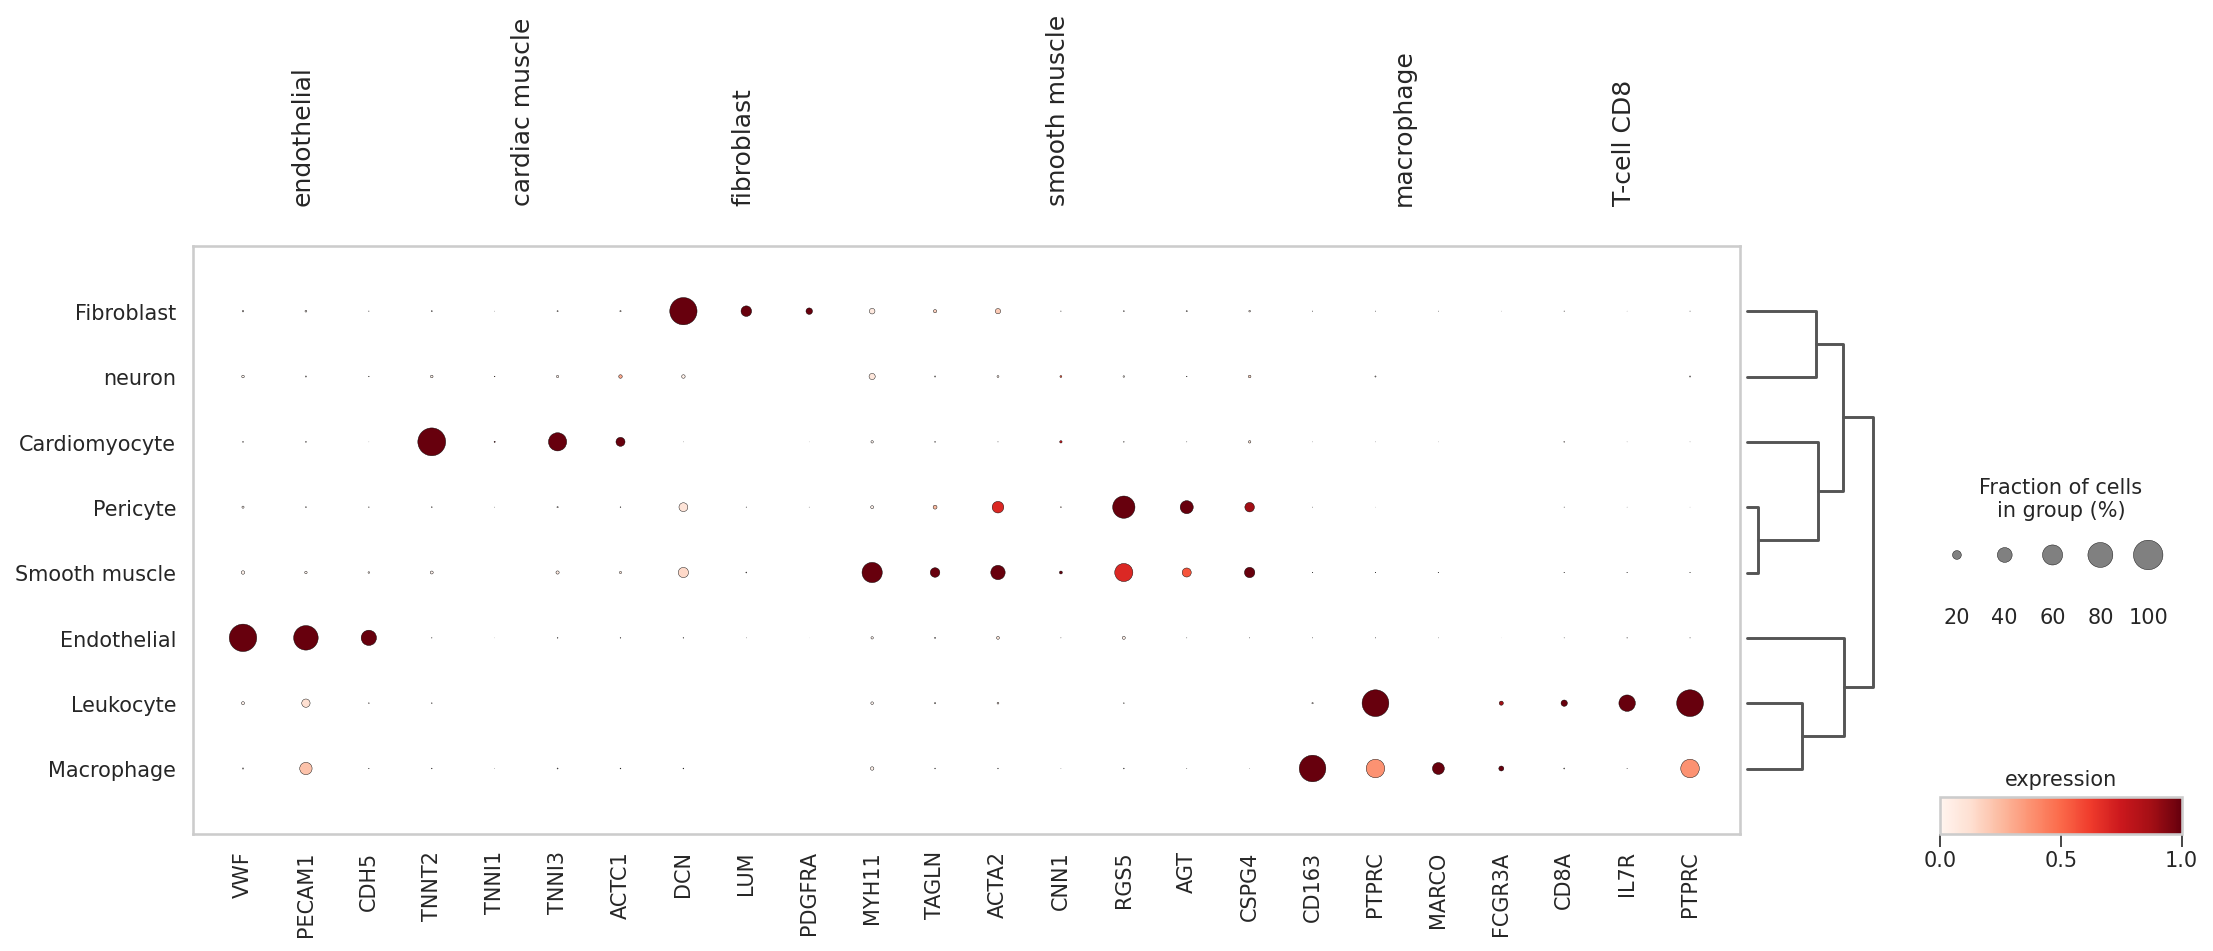

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(17,7), gridspec_kw={'wspace':0.9})

sc.pl.dotplot(adata, 
              var_names= utils.get_markers(this_sample),
              layer='counts',
              groupby= cell_type_label,
              log=True,
              standard_scale='var',
              colorbar_title = 'expression',
              dendrogram=True, ax = ax1,
              save= this_sample + '_dotplot_celltype_markers.pdf')

## Expression of COVID genes 

In [11]:
# covid entry factors 
covid_entry_genes = ['ACE2', 'TMPRSS2', 'CTSL']
covid_entry_receptors = ['ACE2', 'BSG', 'NRP1', 'DPP4', 'ANPEP', 'ENPEP', 'AGTR2']
covid_entry_proteases = ['TMPRSS2', 'CTSL', 'FURIN', 'PRSS1']